In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Установим красивые дефолтные настройки
### Может быть лень постоянно прописывать
### У графиков параметры цвета, размера, шрифта
### Можно положить их в словарь дефолтных настроек

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Gradient Boosting

In [ ]:
### Генерим датасет

from sklearn.datasets import make_moons

dataset = make_moons(n_samples=1000,
                     noise=0.5,
                     random_state=0)

dataset = pd.DataFrame(np.hstack((dataset[0], dataset[1].reshape(-1, 1))),
                       columns=["x1", "x2", "y"])

dataset.head()

,x1,x2,y
0,2.216430,0.741684,1.0
1,2.057427,0.424853,1.0
2,-0.116847,0.004159,0.0
3,-0.710797,0.210482,1.0
4,0.267548,-0.460654,1.0


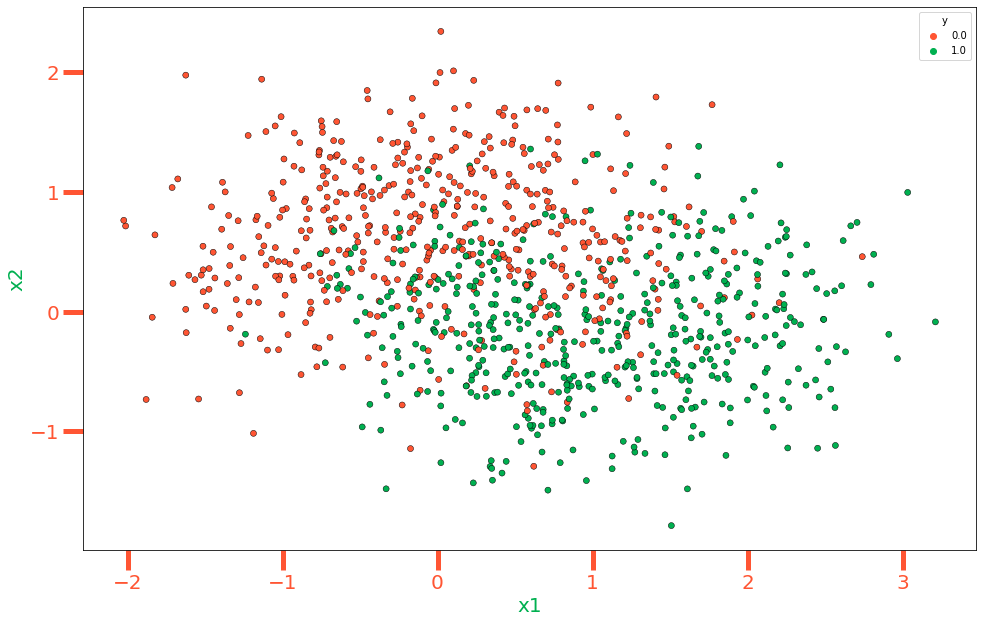

In [ ]:
### Изобразим объекты и раскрасим их в классы

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.scatterplot(x="x1",
                y="x2",
                hue="y",
                edgecolor="k",
                palette=["#FF5533", "#00B050"],
                data=dataset)

plt.show()

In [ ]:
### Разобьем датасет на объекты и таргеты

X = dataset.drop("y", axis=1)
y = dataset["y"]

### Разделим на трейн и тест

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0, 
                                                    test_size=0.2)


In [ ]:
### Обучим градиентный бустинг над деревьями

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   max_depth=2,
                                   n_estimators=500)

model

GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=500)

In [ ]:
model.n_estimators

500

In [ ]:
def learn_boosting_and_plot(estimator=model,
                            X_tr=X_train,
                            X_te=X_test,
                            Y_tr=y_train,
                            Y_te=y_test):
    
    pixel_step = 0.02
    
    X = pd.concat((X_tr, X_te))
    Y = pd.concat((Y_tr, Y_te))
    
    x1_min, x1_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    x2_min, x2_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1

    ### Генерим много-много точек на плоскости

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, pixel_step),
        np.arange(x2_min, x2_max, pixel_step)
    )

    
    ### Обучаем модель на трейне
    
    estimator.fit(X_tr, Y_tr)
    
    ### Считаем качество на обоих фолдах
    
    accuracy_train = estimator.score(X_tr, Y_tr)
    accuracy_test = estimator.score(X_te, Y_te)
    
    ### Для каждой точки даем прогноз, чтобы покрыть поверхности

    Z = estimator.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    ### Заполняем пространство

    cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    ### Рисуем точечки и обученные области

    for i, n, c in zip(range(2), model.classes_, ["#FF5533", "#00B050"]):
        idx = np.where(y == i)
        plt.scatter(
            X.values[idx, 0],
            X.values[idx, 1],
            c=c,
            s=20,
            edgecolor="k",
            label="Class %s" % n,
        )
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.legend(loc="upper right")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Boosting with {estimator.n_estimators} estimators")
    
    return accuracy_train, accuracy_test

(1.0, 0.755)

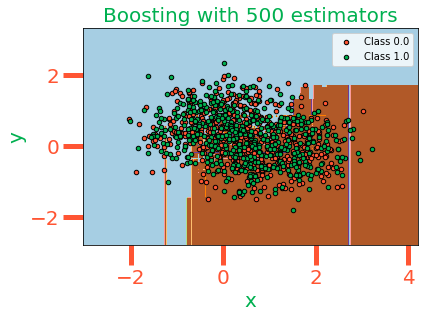

In [ ]:
learn_boosting_and_plot(model)

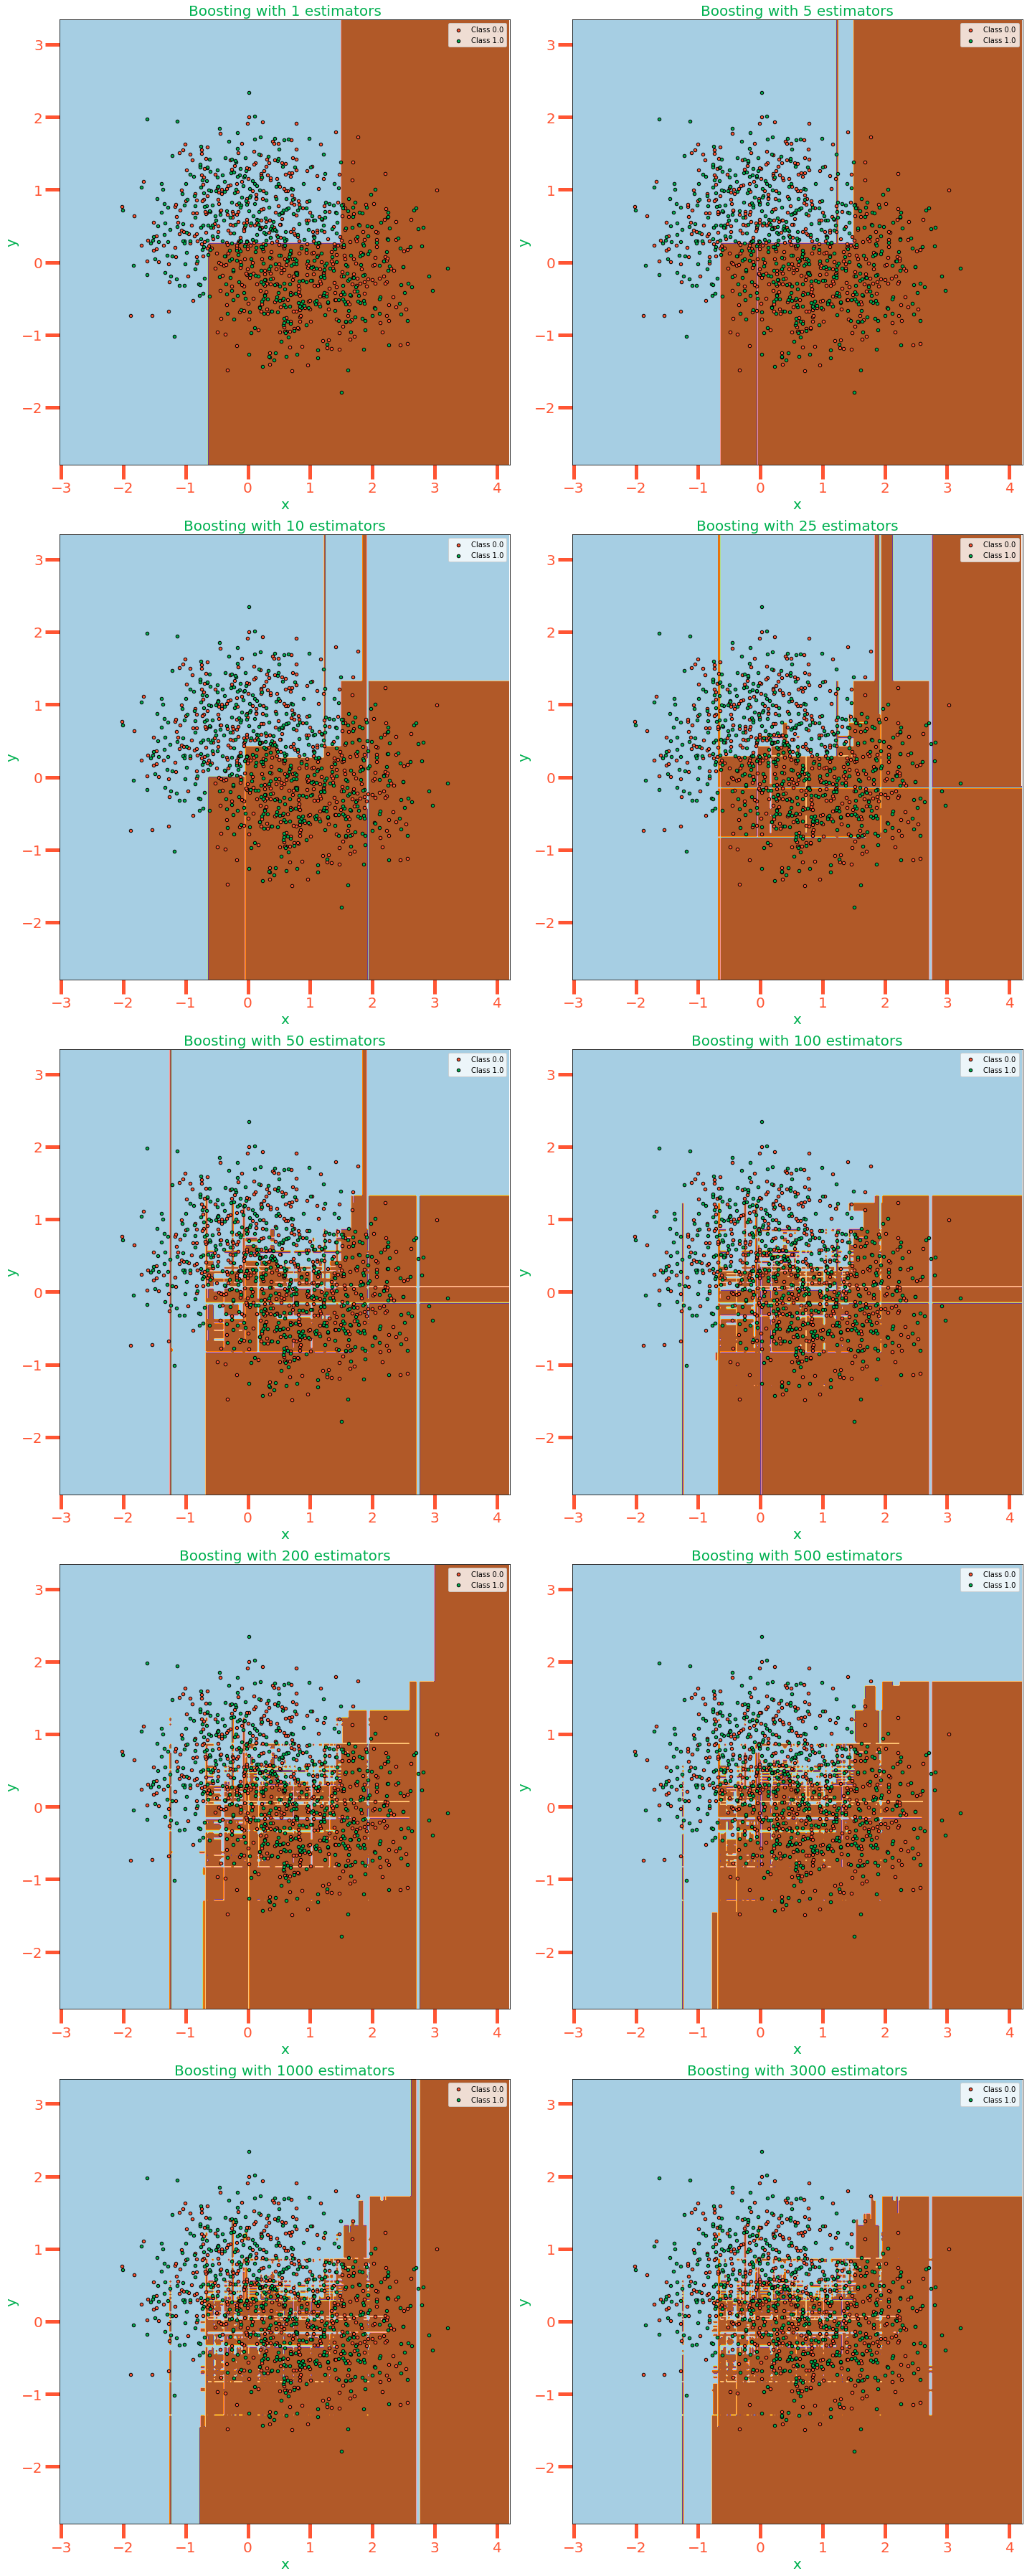

In [ ]:
estimators_num = [1, 5, 10, 25, 50, 100, 200, 500, 1000, 3000]

fig = plt.figure()
fig.set_size_inches(20, 50)

train_accuracies = []
test_accuracies = []


for i, s in enumerate(estimators_num):
    
    model.n_estimators = s
    ax_ = fig.add_subplot(5, 2, i+1)
    
    outputs = learn_boosting_and_plot(model)
    
    train_accuracies.append(outputs[0])
    test_accuracies.append(outputs[1])

fig.tight_layout()
plt.show()

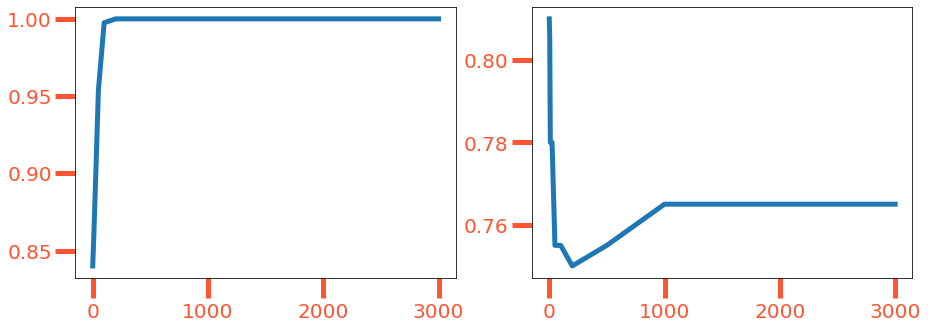

In [ ]:
### Изобразим кривые качества на трейне и тесте

fig = plt.figure()
fig.set_size_inches(15, 5)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(estimators_num, train_accuracies)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(estimators_num, test_accuracies)

plt.show()

### Поменяем learning_rate и посмотрим, как замедлится композиция!

In [ ]:
### Обучим градиентный бустинг над деревьями

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=500)

model

GradientBoostingClassifier(max_depth=2, n_estimators=500)

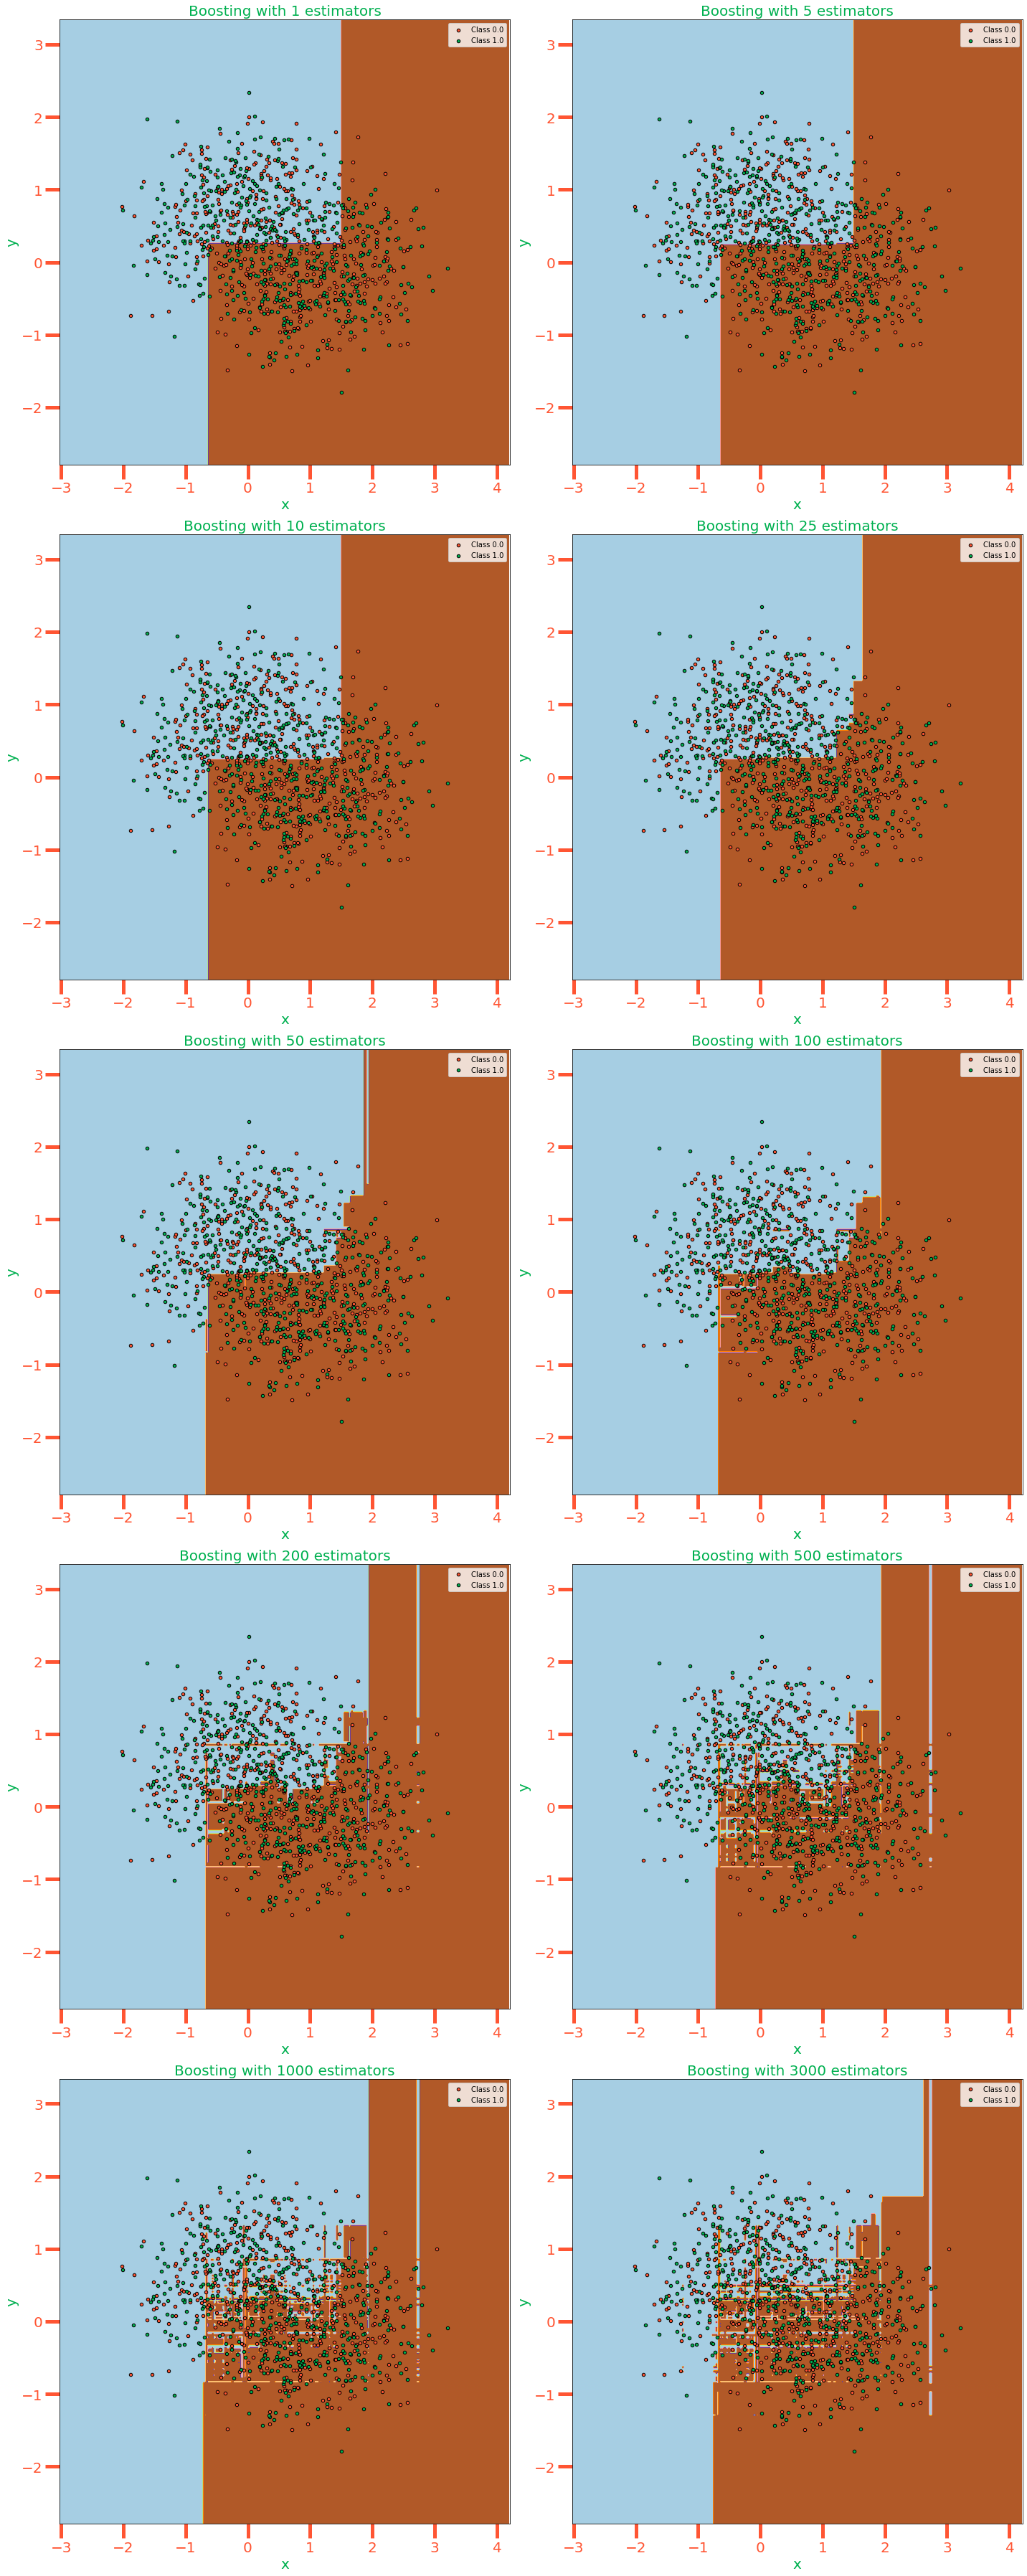

In [ ]:
estimators_num = [1, 5, 10, 25, 50, 100, 200, 500, 1000, 3000]

fig = plt.figure()
fig.set_size_inches(20, 50)

train_accuracies = []
test_accuracies = []


for i, s in enumerate(estimators_num):
    
    model.n_estimators = s
    ax_ = fig.add_subplot(5, 2, i+1)
    
    outputs = learn_boosting_and_plot(model)
    
    train_accuracies.append(outputs[0])
    test_accuracies.append(outputs[1])

fig.tight_layout()
plt.show()

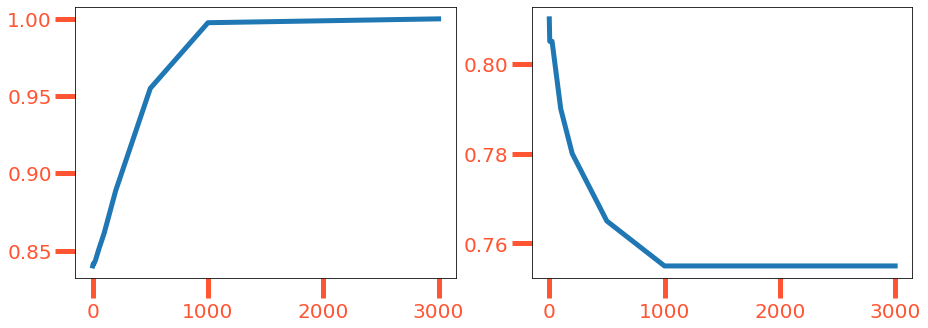

In [ ]:
### Изобразим кривые качества на трейне и тесте

fig = plt.figure()
fig.set_size_inches(15, 5)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(estimators_num, train_accuracies)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(estimators_num, test_accuracies)

plt.show()

### Популярные реализации градиентного бустинга

### XGboost

$$
\sum_i^n L(y_i, a^{(N-1)}(x_i) + b_N (x_i)) \rightarrow min
$$

Ряд Тейлора:

$$
e^x = 1 + \frac{x}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} + ...
$$

Можно применять и в многомерном случае

$$
\sum_i^n L(y_i, a^{(N-1)}(x_i) + b_N (x_i)) \approx \sum_i^n (L(y_i, a^{(N-1)}(x_i)) - s_i \cdot b(x_i) + \frac{1}{2}\cdot h_i \cdot b^2(x_i))
$$

где через $h_i$ обозначены вторые производные по сдвигам

Если вместо $h_i$ положить единички, то получится ровно та задача аппроксимации сдвигов, которую решает обычный градиентный бустинг:

$$
\sum_i^n (b(x_i)-s_i)^2 = \sum_i^n (b^2(x_i) - 2\cdot s_i \cdot b(x_i) + s_i^2) = 
$$

$$
\sum_i^n ( - 2\cdot s_i \cdot b(x_i) + b^2(x_i) + s_i^2) = 2 \cdot \sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i) + \frac{1}{2} + s_i^2)
$$

При оптимизации константы как множитель и как слагаемое можно опустить:

$$
\sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i)) \rightarrow min
$$

Таким образом, XGboost совершенствует классический градиентный бустинг тем фактом, что при приближении сдвигов новым алгоритмом еще и учитывает вторые производные (кривизну) изначально минимизируемого функционала. Так же в XGboost реализациях обычно учитывается регуляризация деревьев типа

$$
\sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i)) + \gamma \cdot J + \frac{\lambda}{2}\cdot \sum_j^J b_j^2 \rightarrow min
$$

Считается самым оптимизированным бустингом: огромное комьюнити, перебор порогов осуществляется с некоторым шагом, а не полным перебором и т.д.

### Catboost

Реализация Яндекса, обладающая рядом особенностей:

1. Симметричные деревья
2. Встроенная обработка категориальных признаков
3. Позволяет строить вершины с большим количеством потомков (например, может классно работать при наличии категорий с большим количеством уникальных значений)
4. Бустрапирует выборку при обучении
5. и т.д.

Наверное, стоит сказать, что это лучшее решение, работающее из коробки без особого подбора гиперпараметров.

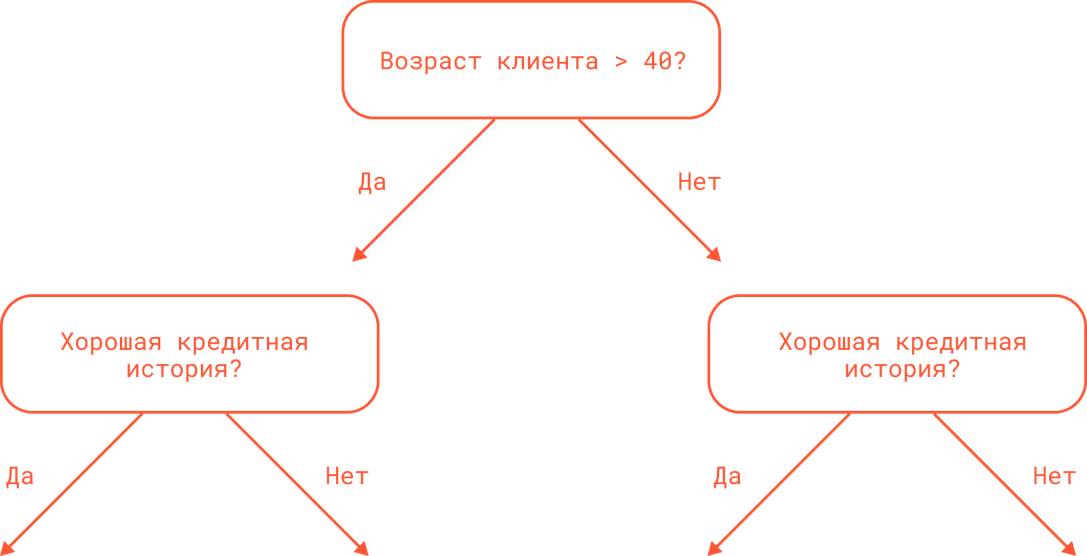

### LightGBM

Разработка Microsoft! 

1. С точки зрения работы с категориями, делит их на 2 подгруппы и работает как с бинарной категорией
2. Строит односторонние деревья, из-за чего почти всегда опережает остальные реализации по скорости работы

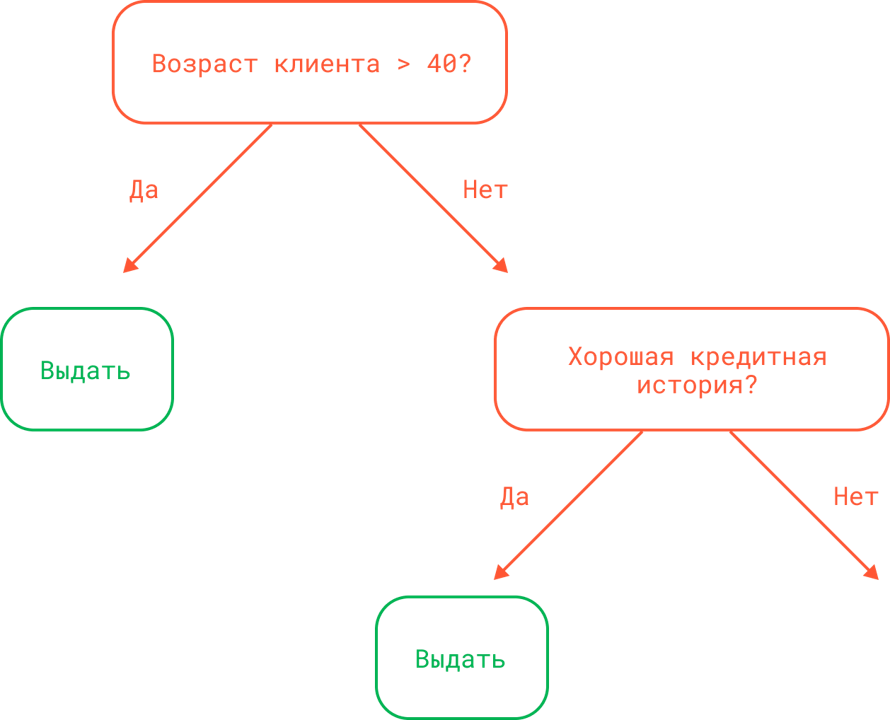

### Бустинг в реальной задаче и сравнение результатов с бэггингом

In [ ]:
X_train = pd.read_csv("X_train_updated.csv")
X_test = pd.read_csv("X_test_updated.csv")

y_train = pd.read_csv("y_train_updated.csv")
y_test = pd.read_csv("y_test_updated.csv")

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X_test[object_cols] = X_test[object_cols].astype(str)
X_train[object_cols] = X_train[object_cols].astype(str)

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

cat_cols = cols_for_ohe_idx + cols_for_mte_idx

In [ ]:
!pip install catboost

You should consider upgrading via the 'c:\users\gigabyte\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [ ]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor()

catboost.fit(X_train, y_train, cat_features=cat_cols)

Learning rate set to 0.067399
0:	learn: 0.8430170	total: 212ms	remaining: 3m 31s
1:	learn: 0.8142942	total: 248ms	remaining: 2m 3s
2:	learn: 0.7885545	total: 285ms	remaining: 1m 34s
3:	learn: 0.7649458	total: 317ms	remaining: 1m 18s
4:	learn: 0.7434233	total: 355ms	remaining: 1m 10s
5:	learn: 0.7242734	total: 390ms	remaining: 1m 4s
6:	learn: 0.7070885	total: 430ms	remaining: 1m 1s
7:	learn: 0.6909883	total: 465ms	remaining: 57.6s
8:	learn: 0.6760970	total: 500ms	remaining: 55.1s
9:	learn: 0.6632929	total: 534ms	remaining: 52.9s
10:	learn: 0.6514407	total: 572ms	remaining: 51.5s
11:	learn: 0.6409061	total: 606ms	remaining: 49.9s
12:	learn: 0.6314310	total: 644ms	remaining: 48.9s
13:	learn: 0.6225399	total: 679ms	remaining: 47.8s
14:	learn: 0.6145038	total: 717ms	remaining: 47.1s
15:	learn: 0.6075041	total: 750ms	remaining: 46.2s
16:	learn: 0.6011346	total: 787ms	remaining: 45.5s
17:	learn: 0.5949747	total: 821ms	remaining: 44.8s
18:	learn: 0.5896610	total: 860ms	remaining: 44.4s
19:	lea

160:	learn: 0.5136774	total: 6.49s	remaining: 33.8s
161:	learn: 0.5136599	total: 6.52s	remaining: 33.7s
162:	learn: 0.5135192	total: 6.56s	remaining: 33.7s
163:	learn: 0.5134065	total: 6.59s	remaining: 33.6s
164:	learn: 0.5132573	total: 6.63s	remaining: 33.5s
165:	learn: 0.5131412	total: 6.66s	remaining: 33.5s
166:	learn: 0.5130739	total: 6.7s	remaining: 33.4s
167:	learn: 0.5128379	total: 6.73s	remaining: 33.4s
168:	learn: 0.5126593	total: 6.77s	remaining: 33.3s
169:	learn: 0.5125544	total: 6.81s	remaining: 33.2s
170:	learn: 0.5123653	total: 6.84s	remaining: 33.2s
171:	learn: 0.5122710	total: 6.88s	remaining: 33.1s
172:	learn: 0.5121028	total: 7s	remaining: 33.4s
173:	learn: 0.5119875	total: 7.03s	remaining: 33.4s
174:	learn: 0.5118536	total: 7.07s	remaining: 33.3s
175:	learn: 0.5116877	total: 7.1s	remaining: 33.3s
176:	learn: 0.5115850	total: 7.14s	remaining: 33.2s
177:	learn: 0.5114030	total: 7.18s	remaining: 33.2s
178:	learn: 0.5112539	total: 7.25s	remaining: 33.2s
179:	learn: 0.511

323:	learn: 0.4951709	total: 12.8s	remaining: 26.6s
324:	learn: 0.4950729	total: 12.8s	remaining: 26.6s
325:	learn: 0.4949646	total: 12.8s	remaining: 26.5s
326:	learn: 0.4949135	total: 12.9s	remaining: 26.5s
327:	learn: 0.4947785	total: 12.9s	remaining: 26.5s
328:	learn: 0.4947012	total: 12.9s	remaining: 26.4s
329:	learn: 0.4945856	total: 13s	remaining: 26.4s
330:	learn: 0.4945223	total: 13s	remaining: 26.3s
331:	learn: 0.4944428	total: 13.1s	remaining: 26.3s
332:	learn: 0.4943823	total: 13.1s	remaining: 26.3s
333:	learn: 0.4943100	total: 13.2s	remaining: 26.2s
334:	learn: 0.4940960	total: 13.2s	remaining: 26.2s
335:	learn: 0.4940465	total: 13.2s	remaining: 26.1s
336:	learn: 0.4939766	total: 13.3s	remaining: 26.1s
337:	learn: 0.4938314	total: 13.3s	remaining: 26s
338:	learn: 0.4936857	total: 13.3s	remaining: 26s
339:	learn: 0.4936459	total: 13.4s	remaining: 26s
340:	learn: 0.4936237	total: 13.4s	remaining: 25.9s
341:	learn: 0.4934993	total: 13.4s	remaining: 25.9s
342:	learn: 0.4934431	

487:	learn: 0.4808903	total: 18.8s	remaining: 19.7s
488:	learn: 0.4807269	total: 18.8s	remaining: 19.7s
489:	learn: 0.4806693	total: 18.9s	remaining: 19.7s
490:	learn: 0.4806054	total: 18.9s	remaining: 19.6s
491:	learn: 0.4805281	total: 19s	remaining: 19.6s
492:	learn: 0.4804159	total: 19s	remaining: 19.5s
493:	learn: 0.4803465	total: 19.1s	remaining: 19.6s
494:	learn: 0.4802653	total: 19.1s	remaining: 19.5s
495:	learn: 0.4801966	total: 19.2s	remaining: 19.5s
496:	learn: 0.4801457	total: 19.2s	remaining: 19.4s
497:	learn: 0.4800056	total: 19.2s	remaining: 19.4s
498:	learn: 0.4799599	total: 19.3s	remaining: 19.3s
499:	learn: 0.4798151	total: 19.4s	remaining: 19.4s
500:	learn: 0.4797596	total: 19.4s	remaining: 19.3s
501:	learn: 0.4797133	total: 19.4s	remaining: 19.3s
502:	learn: 0.4796142	total: 19.5s	remaining: 19.2s
503:	learn: 0.4795302	total: 19.5s	remaining: 19.2s
504:	learn: 0.4794644	total: 19.5s	remaining: 19.1s
505:	learn: 0.4793438	total: 19.6s	remaining: 19.1s
506:	learn: 0.47

647:	learn: 0.4683193	total: 25.4s	remaining: 13.8s
648:	learn: 0.4682771	total: 25.4s	remaining: 13.7s
649:	learn: 0.4682571	total: 25.4s	remaining: 13.7s
650:	learn: 0.4682531	total: 25.4s	remaining: 13.6s
651:	learn: 0.4681350	total: 25.5s	remaining: 13.6s
652:	learn: 0.4680468	total: 25.5s	remaining: 13.6s
653:	learn: 0.4680441	total: 25.5s	remaining: 13.5s
654:	learn: 0.4679170	total: 25.6s	remaining: 13.5s
655:	learn: 0.4678696	total: 25.6s	remaining: 13.4s
656:	learn: 0.4678223	total: 25.6s	remaining: 13.4s
657:	learn: 0.4677206	total: 25.7s	remaining: 13.3s
658:	learn: 0.4676673	total: 25.7s	remaining: 13.3s
659:	learn: 0.4675157	total: 25.8s	remaining: 13.3s
660:	learn: 0.4673736	total: 25.8s	remaining: 13.2s
661:	learn: 0.4673057	total: 25.8s	remaining: 13.2s
662:	learn: 0.4672675	total: 25.9s	remaining: 13.1s
663:	learn: 0.4672154	total: 25.9s	remaining: 13.1s
664:	learn: 0.4670555	total: 25.9s	remaining: 13.1s
665:	learn: 0.4670145	total: 26s	remaining: 13s
666:	learn: 0.46

809:	learn: 0.4574670	total: 31.4s	remaining: 7.37s
810:	learn: 0.4574030	total: 31.4s	remaining: 7.33s
811:	learn: 0.4573553	total: 31.5s	remaining: 7.29s
812:	learn: 0.4572841	total: 31.5s	remaining: 7.25s
813:	learn: 0.4571719	total: 31.6s	remaining: 7.21s
814:	learn: 0.4570978	total: 31.6s	remaining: 7.17s
815:	learn: 0.4569864	total: 31.6s	remaining: 7.13s
816:	learn: 0.4569274	total: 31.7s	remaining: 7.09s
817:	learn: 0.4568397	total: 31.7s	remaining: 7.05s
818:	learn: 0.4567524	total: 31.7s	remaining: 7.01s
819:	learn: 0.4566726	total: 31.8s	remaining: 6.97s
820:	learn: 0.4566224	total: 31.8s	remaining: 6.94s
821:	learn: 0.4565327	total: 31.8s	remaining: 6.9s
822:	learn: 0.4564604	total: 31.9s	remaining: 6.86s
823:	learn: 0.4563753	total: 31.9s	remaining: 6.82s
824:	learn: 0.4563160	total: 32s	remaining: 6.78s
825:	learn: 0.4562807	total: 32s	remaining: 6.74s
826:	learn: 0.4562165	total: 32.1s	remaining: 6.71s
827:	learn: 0.4560778	total: 32.1s	remaining: 6.67s
828:	learn: 0.456

968:	learn: 0.4464247	total: 37.6s	remaining: 1.2s
969:	learn: 0.4464125	total: 37.6s	remaining: 1.16s
970:	learn: 0.4463758	total: 37.7s	remaining: 1.13s
971:	learn: 0.4462955	total: 37.7s	remaining: 1.09s
972:	learn: 0.4462517	total: 37.8s	remaining: 1.05s
973:	learn: 0.4462252	total: 37.8s	remaining: 1.01s
974:	learn: 0.4460725	total: 37.9s	remaining: 972ms
975:	learn: 0.4459946	total: 38s	remaining: 933ms
976:	learn: 0.4459144	total: 38s	remaining: 894ms
977:	learn: 0.4458426	total: 38s	remaining: 855ms
978:	learn: 0.4458118	total: 38.1s	remaining: 816ms
979:	learn: 0.4457064	total: 38.1s	remaining: 777ms
980:	learn: 0.4456278	total: 38.1s	remaining: 739ms
981:	learn: 0.4455559	total: 38.2s	remaining: 700ms
982:	learn: 0.4455099	total: 38.2s	remaining: 661ms
983:	learn: 0.4454150	total: 38.2s	remaining: 622ms
984:	learn: 0.4453295	total: 38.3s	remaining: 583ms
985:	learn: 0.4452678	total: 38.3s	remaining: 544ms
986:	learn: 0.4451921	total: 38.4s	remaining: 505ms
987:	learn: 0.44515

In [ ]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = catboost.predict(X_train)
test_preds = catboost.predict(X_test)

train_error = np.mean((train_preds - y_train.values.ravel())**2)
test_error = np.mean((test_preds - y_test.values.ravel())**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")

Качество на трейне: 0.206
Качество на тесте: 0.326
